In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
from scipy.stats import wasserstein_distance as wd

In [26]:
#define distribution functions
#N is the nuber of points
#dx is the peak sepration before normalization
#for the double-peak:
def double_norm(N=100,dx=1):
    n=int(N/2)
    x=np.concatenate((np.random.normal(0, 1,N-n),np.random.normal(dx, 1,n),),axis=0)
    return (x-x.mean())/x.std()

#for the triple-peak
def triple_norm(N=100,dx=1):
    n=int(N/5)
    x=np.concatenate((np.random.normal(0, 1,N-2*n),np.random.normal(-dx, 1,n),np.random.normal(dx, 1,n),),axis=0)
    return (x-x.mean())/x.std()

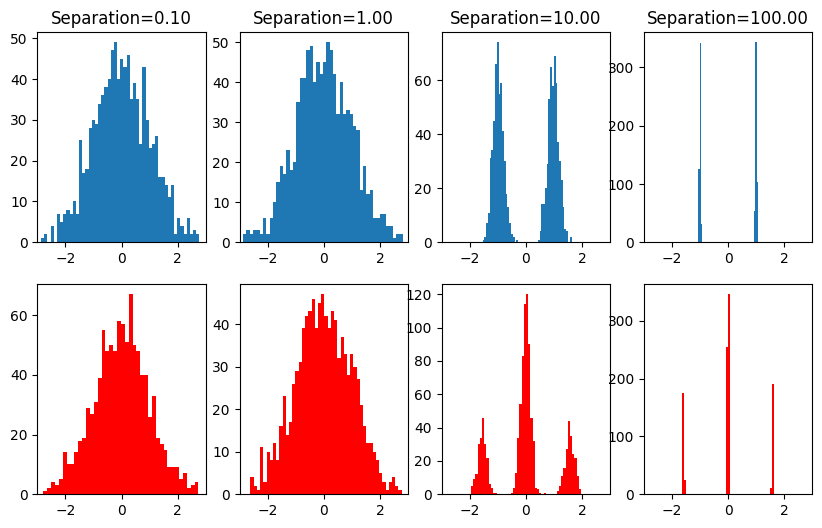

In [27]:
#plot the distributions for differen seprations and N=1000

fig,axs=plt.subplots(2,4,figsize=(10,6))
#double-peak
for i in range(4):
    sep=10**((i-1))
    axs[0,i].hist(double_norm(1000,sep),bins=50)
    axs[0,i].set_title('Separation='+f"{sep:.2f}")
    axs[0,i].set_xlim([-3,3])
#triple-peak
for i in range(4):
    sep=10**((i-1))
    axs[1,i].hist(triple_norm(1000,sep),bins=50,color='r')
    #axs[0,i].set_title('Separation='+f"{sep:.2f}")
    axs[1,i].set_xlim([-3,3])


In [28]:
#Calculate Anderson-Darling k-sample significance level for the above distributions
for i in range(4):
    sep=10**((i-1))
    x=double_norm(10000,sep)
    y=triple_norm(10000,sep)
    res = stats.anderson_ksamp([x,y])
    print("separation=",sep,"Significance level=",res.significance_level)



separation= 0.1 Significance level= 0.25
separation= 1 Significance level= 0.25
separation= 10 Significance level= 0.001
separation= 100 Significance level= 0.001


<ipython-input-28-28635c54b03e>:6: UserWarning: p-value capped: true value larger than 0.25
  res = stats.anderson_ksamp([x,y])
<ipython-input-28-28635c54b03e>:6: UserWarning: p-value floored: true value smaller than 0.001
  res = stats.anderson_ksamp([x,y])


In [29]:
#prepare eatures for the heatmap
#number of values for the distribution sizes
N_points=30

#number of values for the peak separations
N_sep=50

#create lists to use as axis labels, skipping some values
N=[int(10**(i//10+2)*(i%10+1)) for i in range(N_points)]
sep=[1+0.05*j for j in range(N_sep)]
Ns=["%d" % x for x in N]
seps=["%.1f" % x for x in sep]
#this is where we skip some labels
for i in range(N_sep):
    if i%5!=0:
        seps[i]=''

for i in range(N_points):
    if i%2!=0:
        Ns[i]=''


In [30]:
#create heatmap data usiuing Anderson-Darling k-sample significance level
data=np.zeros([N_sep,N_points])

for i in range(N_sep):
    for j in range(N_points):

        x=list(double_norm(N[j],sep[i]))
        y=list(triple_norm(N[j],sep[i]))
        res = stats.anderson_ksamp([x,y])
        data[i,j]=res.significance_level



<ipython-input-30-96335bdbe888>:9: UserWarning: p-value capped: true value larger than 0.25
  res = stats.anderson_ksamp([x,y])
<ipython-input-30-96335bdbe888>:9: UserWarning: p-value floored: true value smaller than 0.001
  res = stats.anderson_ksamp([x,y])


Text(0.5, 1.0, 'Anderson-Darling k-sample significance level')

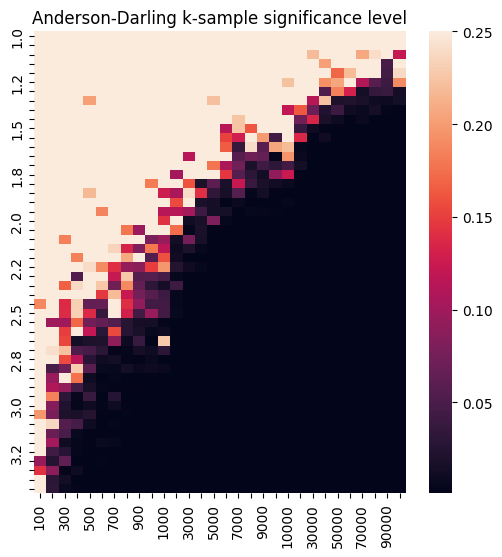

In [31]:
#plot heatmap
df=pd.DataFrame(data)
fig, ax = plt.subplots (figsize=(6, 6))
sns.heatmap(df,xticklabels=Ns,yticklabels=seps)
plt.title("Anderson-Darling k-sample significance level")



In [32]:
#define distribution likeness to compare histograms
#sigma defines the speread of the histograms, taken into coparison
# by default, the data withing about  3 standard deviations are considered
def distr_likeness(x,y,sigma=3):
    #find minumum size for the distributions
    M=min(x.size,y.size)
    #define number of bins
    MM=max(20,int(M/50))
    #define bins positions
    bins=[sigma*i/MM for i in range(-MM,MM)]
    #bins=50
    xx,bins=np.histogram(x,bins=bins,density=True)
    yy,bins=np.histogram(y,bins=bins,density=True)
    #yy=hi1[0]#-hi1[0].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx,yy)
    return (xx,yy,r_value)



Text(0.5, 1.0, 'Pearson correlation for two histograms')

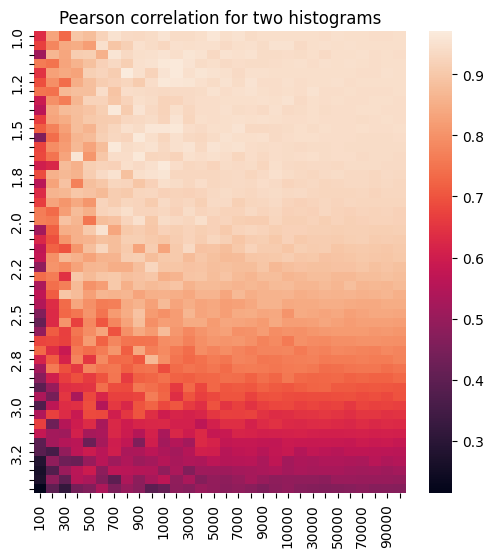

In [33]:
#plot heatmap data by comparing two histograms
for i in range(N_sep):
    for j in range(N_points):

        x=(double_norm(N[j],sep[i]))
        y=(triple_norm(N[j],sep[i]))
        _,_,res = distr_likeness(x,y,sigma=3)
        data[i,j]=res
df=pd.DataFrame(data)
fig, ax = plt.subplots (figsize=(6, 6))
sns.heatmap(df,xticklabels=Ns,yticklabels=seps)
plt.title("Pearson correlation for two histograms")

Text(0.5, 1.0, 'separation=3')

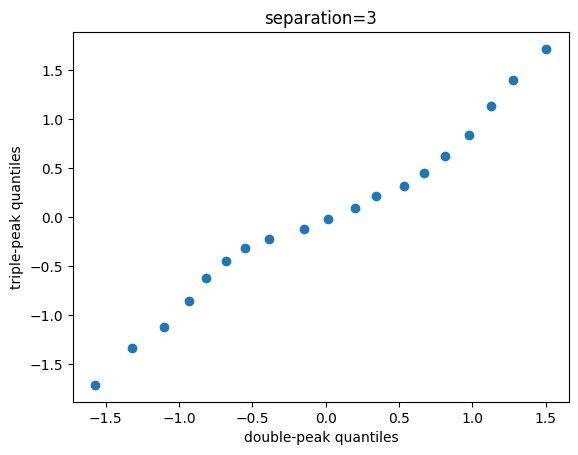

In [34]:
q=[(i+1)*0.05 for i in range(19)]
x=(double_norm(1000,3))
y=(triple_norm(1000,3))
xx=np.quantile(x,q)
yy=np.quantile(y,q)
plt.scatter(xx,yy)
plt.xlabel('double-peak quantiles')
plt.ylabel('triple-peak quantiles')
plt.title("separation=3")


In [35]:
#define likness function for quantile-quantile plots
#q is the number of quantiles to consider
def qq_likeness(x,y,q=20):
    qq=np.array([(i+1)*1/q for i in range(q-1)])
    xx=np.quantile(x,qq)
    yy=np.quantile(y,qq)
    coef=np.polyfit(xx,yy,3,w=qq*(1-qq))
    r=(coef[2]**2/(coef[0]**2+coef[1]**2+coef[2]**2))
    return xx,yy,r

Text(0.5, 1.0, 'Pearson correlation for quantile-quantile plot')

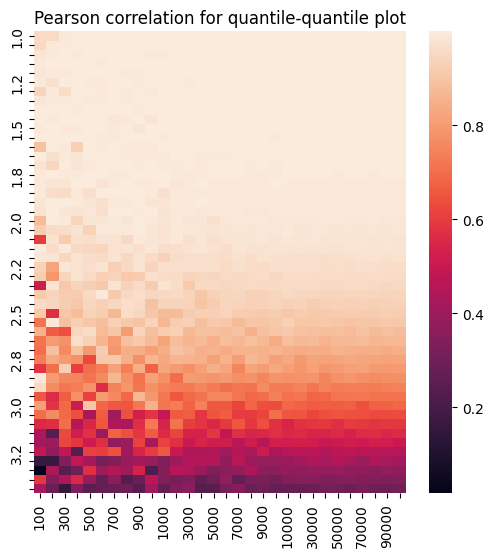

In [36]:
for i in range(N_sep):
    for j in range(N_points):

        x=(double_norm(N[j],sep[i]))
        y=(triple_norm(N[j],sep[i]))
        _,_,res=qq_likeness(x,y)
        data[i,j]=res
df=pd.DataFrame(data)
fig, ax = plt.subplots (figsize=(6, 6))
sns.heatmap(df,xticklabels=Ns,yticklabels=seps)
plt.title("Pearson correlation for quantile-quantile plot")